In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from utils import get_mol, get_C_atom_counts, get_heavy_atom_counts
import gseapy as gp
from collections import defaultdict, Counter
from scipy.stats import mannwhitneyu

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = 'Arial'
import seaborn as sns

from utils import get_protein_info, family_parser
from tqdm import tqdm

import warnings
warnings.filterwarnings(action='ignore')

### Load TTD & Drugbank data
+ TTD: 
> + 1.0 Raw data processing and extraction were done in `../DrugPartition/0713-DataProcess-TTD.ipynb & 0714-DataExtract-TTD.ipynb`
> + 1.1 approved drug definition: highest_status in `'Application submitted', 'Approval submitted', 'Approved', 'Approved (orphan drug)', 'BLA submitted', 'NDA filed', 'Discontinued in Phase 4', 'Phase 4', 'Withdrawn from market','approved'`

+ DrugBank:
> + 2.0 Raw data processing and extraction were done in `../DrugPartition/0721-DataProcess-DrugBank.ipynb & 0721-DataExtract-DrugBank.ipynb`
> + 2.1 approved drug definition: `approved` in status & `known_action == yes`

In [2]:
# TTD
with open('./data/Binding_data/TTD_whole_ps_nps_data_top5.pkl', 'rb') as file:
    whole_ps_data = pkl.load(file)

# for ps & nps
ps_partition_drugs = whole_ps_data['ps']['partition'][0]
ps_partition_drugs = ps_partition_drugs - {'OO', '[As+3].[As+3]', '[Bi]'}
ps_partition_drugs.remove('O=C([O-])CN(CCN(CC(=O)[O-])CC(COP(=O)([O-])OC1CCC(c2ccccc2)(c2ccccc2)CC1)N(CC(=O)[O-])CC(=O)[O-])CC(=O)[O-].[H+].[H+].[H+]')
ps_partition_drugs.add('O=C([O-])CN(CCN(CC(=O)[O-])CC(COP(=O)([O-])OC1CCC(c2ccccc2)(c2ccccc2)CC1)N(CC(=O)[O-])CC(=O)[O-])CC(=O)[O-]')
ps_partition_drugs = set([smi for smi in ps_partition_drugs if get_C_atom_counts(get_mol(smi)) > 0])

nps_success_drugs = whole_ps_data['nps']['partition'][0]
# remove molecules with ion
nps_success_drugs = nps_success_drugs - {'[C-]#N.[C-]#N.[C-]#N.[C-]#N.[C-]#N.[Fe+6].[N-]=O','',
                                         'O=[N+]([O-])[O-].O=[N+]([O-])[O-].O=[N+]([O-])[O-].[Ga+3]','NCC(=O)O[Al]', 
                                         '[C-]#N.[C-]#N.[C-]#N.[C-]#N.[C-]#N.[Fe+4].[N-]=O'}
nps_success_drugs = set([smi for smi in nps_success_drugs if get_C_atom_counts(get_mol(smi)) > 0])

all_ttd_drugs = list(ps_partition_drugs.union(nps_success_drugs))
print(len(all_ttd_drugs))


# DrugBank
with open('./data/Binding_data/DrugBank_ps_smiles_top5.pkl', 'rb') as file:
    ps_partition_drugs2, _, ps_partition_dict2, _ = pkl.load(file)
ps_partition_drugs2.remove('O=[As]O[As]=O')
ps_partition_drugs2 = set([smi for smi in ps_partition_drugs2 if get_C_atom_counts(get_mol(smi)) > 0])

with open('./data/Binding_data/DrugBank_nps_smiles_top5.pkl', 'rb') as file:
    nps_success_drugs2, nps_success_dict2 = pkl.load(file)
nps_success_drugs2.remove('')
nps_success_drugs2.remove('N#C[Fe-2](C#N)(C#N)(C#N)(C#N)N=O')
# remove mols without carbon
nps_success_drugs2 = set([smi for smi in nps_success_drugs2 if get_C_atom_counts(get_mol(smi)) > 0])

all_drugbank_drugs = list(ps_partition_drugs2.union(nps_success_drugs2))
print(len(all_drugbank_drugs))

1355
1339


In [3]:
# with open('../Paper1-Submission/Final/1107/Data/Extended_Data_Fig_1/DrugBank_approved_drugs.txt', 'w') as file:
#     for smi in all_drugbank_drugs:
#         file.write(smi + '\n')

# with open('../Paper1-Submission/Final/1107/Data/Extended_Data_Fig_1/TTD_approved_drugs.txt', 'w') as file:
#     for smi in all_ttd_drugs:
#         file.write(smi + '\n')

### Filtration of very large molecules and Union of data
+ Filtration: `heavy atom counts <= 100 & cabon atom counts > 0`
+ union data: `PS-targeting (58 PS-proteins, 346 drugs), NPS-targeting (704 NPS-proteins, 1784 drugs)`

In [3]:
# distribution of heavy atoms counts
all_ttd_heavy_atom_counts = [get_heavy_atom_counts(get_mol(smi)) for smi in all_ttd_drugs]
all_drugbank_heavy_atom_counts = [get_heavy_atom_counts(get_mol(smi)) for smi in all_drugbank_drugs]

# distribution of C atoms counts
all_ttd_C_atom_counts = [get_C_atom_counts(get_mol(smi)) for smi in all_ttd_drugs]
all_drugbank_C_atom_counts = [get_C_atom_counts(get_mol(smi)) for smi in all_drugbank_drugs]

In [6]:
sum([1 for i in all_ttd_C_atom_counts if i <= 50]) / 1355, sum([1 for i in all_drugbank_C_atom_counts if i <= 50]) / 1339

(0.9549815498154982, 0.9671396564600448)

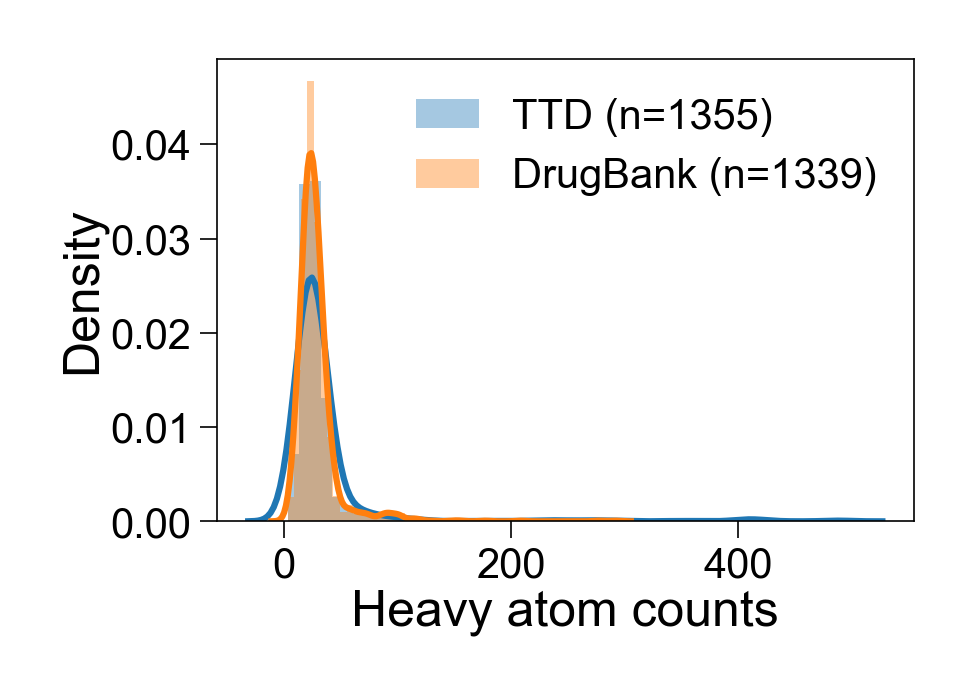

In [5]:
fig, ax = plt.subplots(1, 1, dpi=600, figsize=(1.5,1.))

sns.distplot(all_ttd_heavy_atom_counts, ax=ax, label='TTD (n=1355)', hist=True, kde_kws={'linewidth': 0.75})
sns.distplot(all_drugbank_heavy_atom_counts, ax=ax, label='DrugBank (n=1339)', hist=True, kde_kws={'linewidth': 0.75})
ax.set_xlabel('Heavy atom counts', fontsize=6, labelpad=0.5)
ax.set_ylabel('Density', fontsize=6, labelpad=0.5)
ax.tick_params(labelsize=5, width=0.2, length=2, pad=1)
ax.spines['bottom'].set_linewidth(0.2)
ax.spines['top'].set_linewidth(0.2)
ax.spines['left'].set_linewidth(0.2)
ax.spines['right'].set_linewidth(0.2)
# ax.set_xlim(-10, 10)
ax.legend(fontsize=5, handlelength=1.5, frameon=False)
# ax.set_title('heavy atom counts distribution of approved drugs', fontsize=10)
# plt.savefig('./output/figures/approved_drug_heavy_atoms_dist.pdf', dpi=600, bbox_inches='tight')
plt.savefig('./output/figures/approved_drug_heavy_atoms_dist.png', dpi=600, bbox_inches='tight')

plt.show()

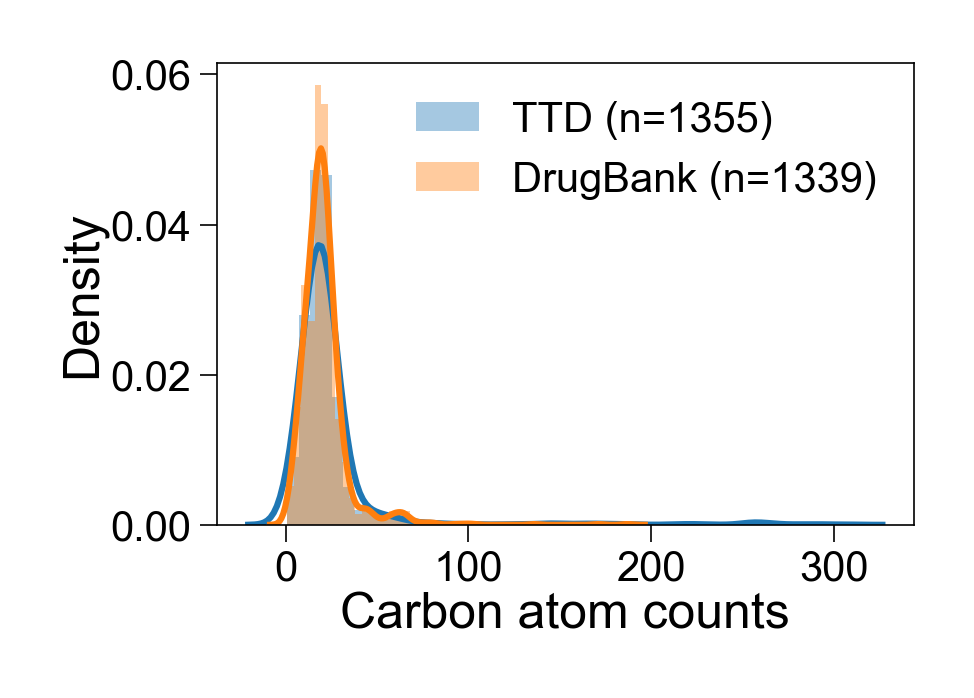

In [6]:
fig, ax = plt.subplots(1, 1, dpi=600, figsize=(1.5,1.))

sns.distplot(all_ttd_C_atom_counts, ax=ax, label='TTD (n=1355)', hist=True, kde_kws={'linewidth': 0.75})
sns.distplot(all_drugbank_C_atom_counts, ax=ax, label='DrugBank (n=1339)', hist=True ,kde_kws={'linewidth': 0.75})
ax.set_xlabel('Carbon atom counts', fontsize=6, labelpad=0.5)
ax.set_ylabel('Density', fontsize=6, labelpad=0.5)
ax.tick_params(labelsize=5, width=0.2, length=2, pad=1)
ax.spines['bottom'].set_linewidth(0.2)
ax.spines['top'].set_linewidth(0.2)
ax.spines['left'].set_linewidth(0.2)
ax.spines['right'].set_linewidth(0.2)
# ax.set_xlim(-10, 10)
ax.legend(fontsize=5, handlelength=1.5, frameon=False)
# ax.set_title('carbon atom counts distribution of approved drugs', fontsize=10)
# plt.savefig('./output/figures/approved_drug_cabon_atoms_dist.pdf', dpi=600, bbox_inches='tight')
plt.savefig('./output/figures/approved_drug_cabon_atoms_dist.png', dpi=600, bbox_inches='tight')

plt.show()

In [7]:
# keep heavy atom counts <= 100

# TTD
ps_partition_drugs = set([smi for smi in ps_partition_drugs if 0 < get_heavy_atom_counts(get_mol(smi)) <= 100])
ps_partition_dict = whole_ps_data['ps']['partition'][1]
ps_partition_dict = {k: [smi for smi in v if smi in ps_partition_drugs] for k, v in ps_partition_dict.items()}
ps_partition_dict = {k: v for k, v in ps_partition_dict.items() if len(v) > 0}

nps_success_drugs = set([smi for smi in nps_success_drugs if 0 < get_heavy_atom_counts(get_mol(smi)) <= 100])
nps_success_dict = whole_ps_data['nps']['partition'][1]
nps_success_dict = {k: [smi for smi in v if smi in nps_success_drugs] for k, v in nps_success_dict.items()}
nps_success_dict = {k: v for k, v in nps_success_dict.items() if len(v) > 0}

print(len(ps_partition_drugs), len(nps_success_drugs))
print(len(ps_partition_drugs.intersection(nps_success_drugs)))
print(len(ps_partition_dict), len(nps_success_dict))
print(len(set(ps_partition_drugs).union(nps_success_drugs)))

# DrugBank
ps_partition_drugs2 = set([smi for smi in ps_partition_drugs2 if 0 < get_heavy_atom_counts(get_mol(smi)) <= 100])
ps_partition_dict2 = {k:[smi for smi in v if smi in ps_partition_drugs2] for k, v in ps_partition_dict2.items()}
ps_partition_dict2 = {k: v for k, v in ps_partition_dict2.items() if len(v) > 0}

nps_success_drugs2 = set([smi for smi in nps_success_drugs2 if 0 < get_heavy_atom_counts(get_mol(smi)) <= 100])
nps_success_dict2 = {k: [smi for smi in v if smi in nps_success_drugs2] for k, v in nps_success_dict2.items()}
nps_success_dict2 = {k: v for k, v in nps_success_dict2.items() if len(v) > 0}

print(len(ps_partition_drugs2), len(nps_success_drugs2))
print(len(ps_partition_drugs2.intersection(nps_success_drugs2)))
print(len(ps_partition_dict2), len(nps_success_dict2))
print(len(ps_partition_drugs2.union(nps_success_drugs2)))

172 1166
23
37 414
1315
207 1180
67
49 641
1320


In [8]:
TTD_targets = list(set(ps_partition_dict.keys()).union(nps_success_dict.keys()))
DrugBank_targets = list(set(ps_partition_dict2.keys()).union(nps_success_dict2.keys()))
print(len(TTD_targets), len(DrugBank_targets), len(set(TTD_targets).intersection(DrugBank_targets)))

TTD_drugs = list(ps_partition_drugs.union(nps_success_drugs))
DrugBank_drugs = list(ps_partition_drugs2.union(nps_success_drugs2))
print(len(set(TTD_drugs).intersection(DrugBank_drugs)))

451 690 314
505


In [7]:
# union all drugs
# whole_drugs_top5 = list(ps_partition_drugs.union(ps_partition_drugs2).union(nps_success_drugs).union(nps_success_drugs2))

# print(len(whole_drugs_top5))

# ps_partition_union_dict, nps_success_union_dict = defaultdict(set), defaultdict(set)
# for k, smis in ps_partition_dict.items():
#     ps_partition_union_dict[k].update(smis)
# for k, smis in ps_partition_dict2.items():
#     ps_partition_union_dict[k].update(smis)
# for k, smis in nps_success_dict.items():
#     nps_success_union_dict[k].update(smis)
# for k, smis in nps_success_dict2.items():
#     nps_success_union_dict[k].update(smis)

# print(len(ps_partition_union_dict), len(nps_success_union_dict))

2130
58 769


In [8]:
# # overlap of ps-partition & nps-success
# all_ps_partition_drugs = set(ps_partition_drugs).union(ps_partition_drugs2)
# all_nps_success_drugs = set(nps_success_drugs).union(nps_success_drugs2)

# print(len(all_ps_partition_drugs), len(all_nps_success_drugs))
# print(len(all_ps_partition_drugs.intersection(all_nps_success_drugs)))

# all_non_partition_drugs = all_nps_success_drugs - all_ps_partition_drugs

# print(len(all_non_partition_drugs))

# non_partition_dict = {k: [smi for smi in v if smi in all_non_partition_drugs] for k, v in nps_success_union_dict.items()}
# non_partition_dict = {k: v for k, v in non_partition_dict.items() if len(v) > 0}
# print(len(non_partition_dict))

346 1870
86
1784
704


In [9]:
# with open('./data/Binding_data/TTD_DrugBank_ps_target_smiles_top5.txt', 'w') as file:
#     for smi in all_ps_partition_drugs:
#         file.write(smi + '\n')

# with open('./data/Binding_data/TTD_DrugBank_nps_target_smiles_top5.txt', 'w') as file:
#     for smi in all_non_partition_drugs:
#         file.write(smi + '\n')

# with open('./data/Binding_data/TTD_DrugBank_ps_nps_dict_top5.pkl', 'wb') as file:
#     pkl.dump((ps_partition_union_dict, non_partition_dict, nps_success_union_dict), file=file)

# get family information of each target
# data_df.to_csv('./data/Protein_info/TTD_DrugBank_target_info.csv', index=False)

### visualization of ps-target & nps-target

In [9]:
with open('./data/Binding_data/TTD_DrugBank_ps_nps_dict_top5.pkl', 'rb') as file:
    ps_target_dict, nps_target_dict, _ = pkl.load(file=file)

data_df = pd.read_csv('./data/Protein_info/TTD_DrugBank_target_info.csv')
ps_new_family_map_uniprots = defaultdict(list)
for uniprot, sf, f in data_df.iloc[:58, :][['uniprot', 'superfamily', 'family']].values:
    if type(sf) == str and sf != '':
        ps_new_family_map_uniprots[sf].append(uniprot)
    elif type(f) == str and f != '':
        ps_new_family_map_uniprots[f].append(uniprot)
    else:
        ps_new_family_map_uniprots['unknown'].append(uniprot)

ps_new_family_counts = {k: len(lst) for k, lst in ps_new_family_map_uniprots.items()}
ps_new_family_counts_sort = sorted(ps_new_family_counts.items(), key=lambda item: item[1], reverse=True)
ps_new_family_counts_sort = dict(ps_new_family_counts_sort)
ps_new_family_map_uniprots_sort = sorted(ps_new_family_map_uniprots.items(), key=lambda item: len(item[1]), reverse=True)
ps_new_family_map_uniprots_sort = dict(ps_new_family_map_uniprots_sort)
ps_new_family_mol_maps = defaultdict(set)
for k, lst in ps_new_family_map_uniprots_sort.items():
    if k != 'unknown':
        for uniprot in lst:
            ps_new_family_mol_maps[k].update([smi for smi in ps_target_dict[uniprot]])
    else:
        for uniprot in lst:
            ps_new_family_mol_maps[uniprot].update([smi for smi in ps_target_dict[uniprot]])

ps_new_family_mol_counts = {k: len(v) for k, v in ps_new_family_mol_maps.items()}

ps_new_family_counts_sort

{'protein kinase': 22,
 'unknown': 5,
 'nuclear hormone receptor': 4,
 'histone deacetylase': 4,
 'type II topoisomerase': 2,
 'heat shock protein 90': 1,
 'class V-like SAM-binding methyltransferase': 1,
 'type IB topoisomerase': 1,
 'ALB/AFP/VDB': 1,
 'transcription factor STAT': 1,
 'ARTD/PARP': 1,
 'annexin': 1,
 'MAP1': 1,
 'APP': 1,
 'protein-tyrosine phosphatase': 1,
 'dwarfin/SMAD': 1,
 'ATP:guanido phosphotransferase': 1,
 'bZIP': 1,
 'heparin-binding growth factors': 1,
 'universal ribosomal protein uL3': 1,
 'peptidase T1B': 1,
 'KEAP1': 1,
 'ferritin': 1,
 'intermediate filament': 1,
 'TRAFAC class myosin-kinesin ATPase': 1,
 'small GTPase': 1}

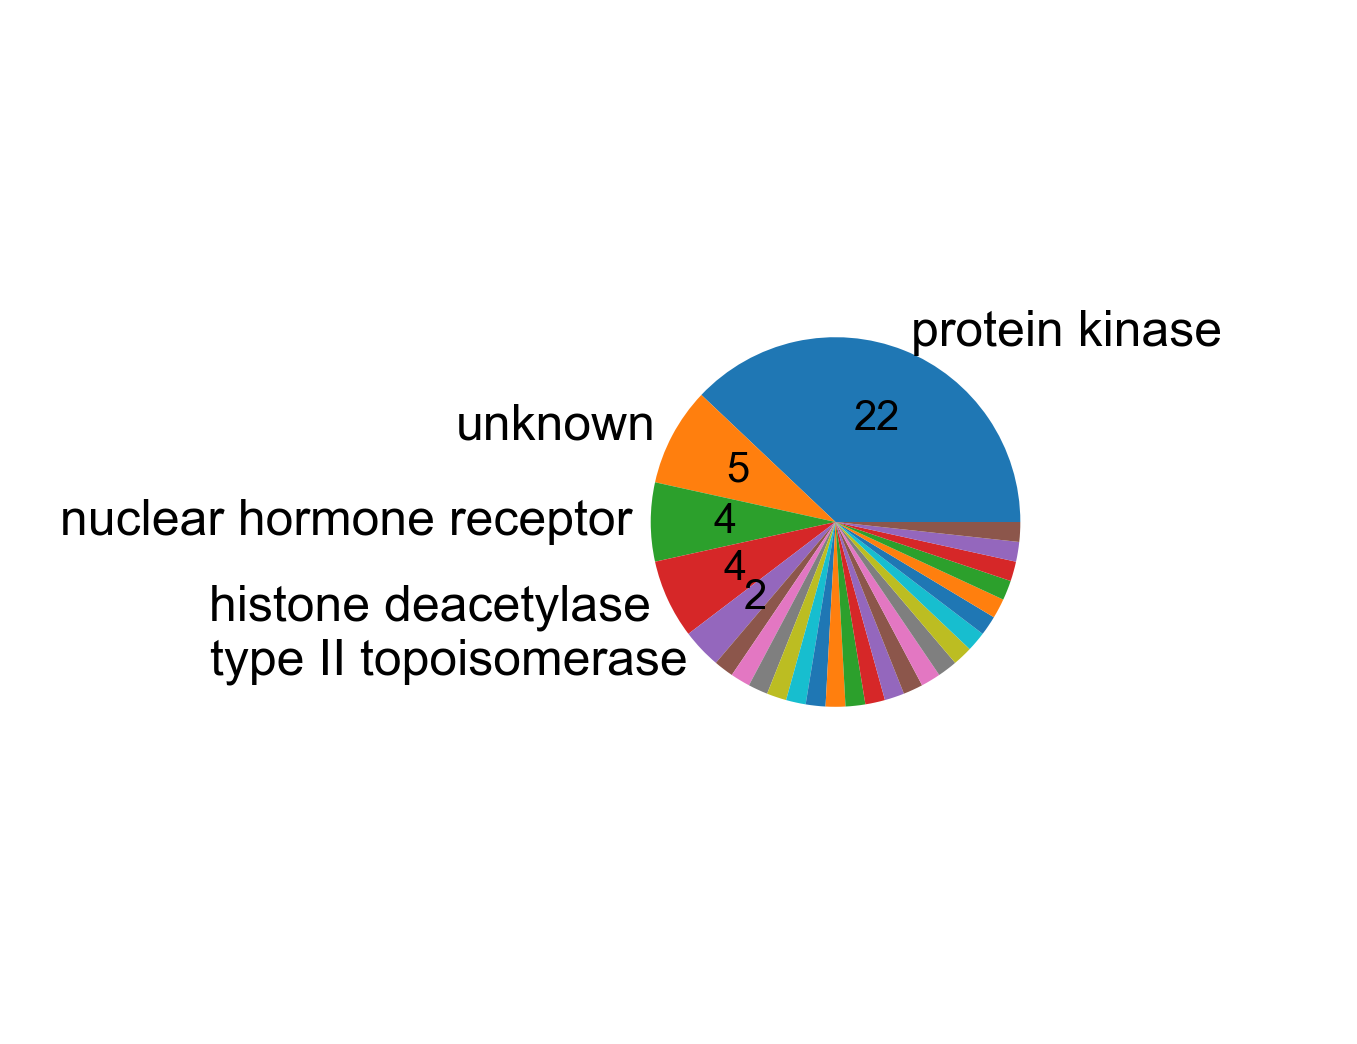

In [10]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        # 同时显示数值和占比的饼图
        # return '{p:.2f}% ({v:d})'.format(p=pct,v=val)
        if val > 1:
            return f'{val}'
        return ''
    return my_autopct

x = list(ps_new_family_counts_sort.values())
labels = [k if v > 1 else '' for k, v in ps_new_family_counts_sort.items()]
plt.figure(figsize=(2,2), dpi=600)
patches, l_text, p_text = plt.pie(
    x, labels=labels, autopct=make_autopct(x),radius=0.5)
for t in p_text:
    t.set_size(5)
for t in l_text:
    t.set_size(6)
# plt.title('Family/superfamily of ps targets', fontsize=7)
plt.savefig('./output/figures/approved_drug_ps_targets_family.png', dpi=600, bbox_inches='tight')
plt.show()

In [11]:
nps_new_family_map_uniprots = defaultdict(list)
for uniprot, sf, f in data_df.iloc[58:, :][['uniprot', 'superfamily', 'family']].values:
    if type(sf) == str and sf != '':
        nps_new_family_map_uniprots[sf].append(uniprot)
    elif type(f) == str and f != '':
        nps_new_family_map_uniprots[f].append(uniprot)
    else:
        nps_new_family_map_uniprots['unknown'].append(uniprot)

nps_new_family_counts = {k: len(lst) for k, lst in nps_new_family_map_uniprots.items()}
nps_new_family_counts_sort = sorted(nps_new_family_counts.items(), key=lambda item: item[1], reverse=True)
nps_new_family_counts_sort = dict(nps_new_family_counts_sort)
nps_new_family_map_uniprots_sort = sorted(nps_new_family_map_uniprots.items(), key=lambda item: len(item[1]), reverse=True)
nps_new_family_map_uniprots_sort = dict(nps_new_family_map_uniprots_sort)
nps_new_family_mol_maps =defaultdict(set)
for k, lst in nps_new_family_map_uniprots_sort.items():
    if k != 'unknown':
        for uniprot in lst:
            nps_new_family_mol_maps[k].update([smi for smi in nps_target_dict[uniprot]])
    else:
        for uniprot in lst:
            nps_new_family_mol_maps[uniprot].update([smi for smi in nps_target_dict[uniprot]])

nps_new_family_mol_counts = {k: len(v) for k, v in nps_new_family_mol_maps.items()}

nps_new_family_counts_sort

{'G-protein coupled receptor 1': 102,
 'ligand-gated ion channel (TC 1.A.9)': 37,
 'unknown': 27,
 'protein kinase': 26,
 'potassium channel': 22,
 'nuclear hormone receptor': 19,
 'glutamate-gated ion channel (TC 1.A.10.1)': 16,
 'cytochrome P450': 13,
 'peptidase S1': 12,
 'cation transport ATPase (P-type) (TC 3.A.3)': 12,
 'alpha-carbonic anhydrase': 12,
 'sodium channel (TC 1.A.1.10)': 10,
 'calcium channel alpha-1 subunit (TC 1.A.1.11)': 10,
 'inward rectifier-type potassium channel (TC 1.A.2.1)': 10,
 'tubulin': 10,
 'cyclic nucleotide phosphodiesterase': 9,
 'adenylyl cyclase class-4/guanylyl cyclase': 8,
 'PMP-22/EMP/MP20': 8,
 'G-protein coupled receptor 3': 7,
 'aldehyde dehydrogenase': 6,
 'ABC transporter': 6,
 'class I-like SAM-binding methyltransferase': 6,
 'SLC12A transporter': 5,
 'glycosyl hydrolase 31': 5,
 'amiloride-sensitive sodium channel (TC 1.A.6)': 5,
 'major facilitator': 4,
 'sodium:neurotransmitter symporter (SNF) (TC 2.A.22)': 4,
 'calycin': 4,
 'PI3/PI4-k

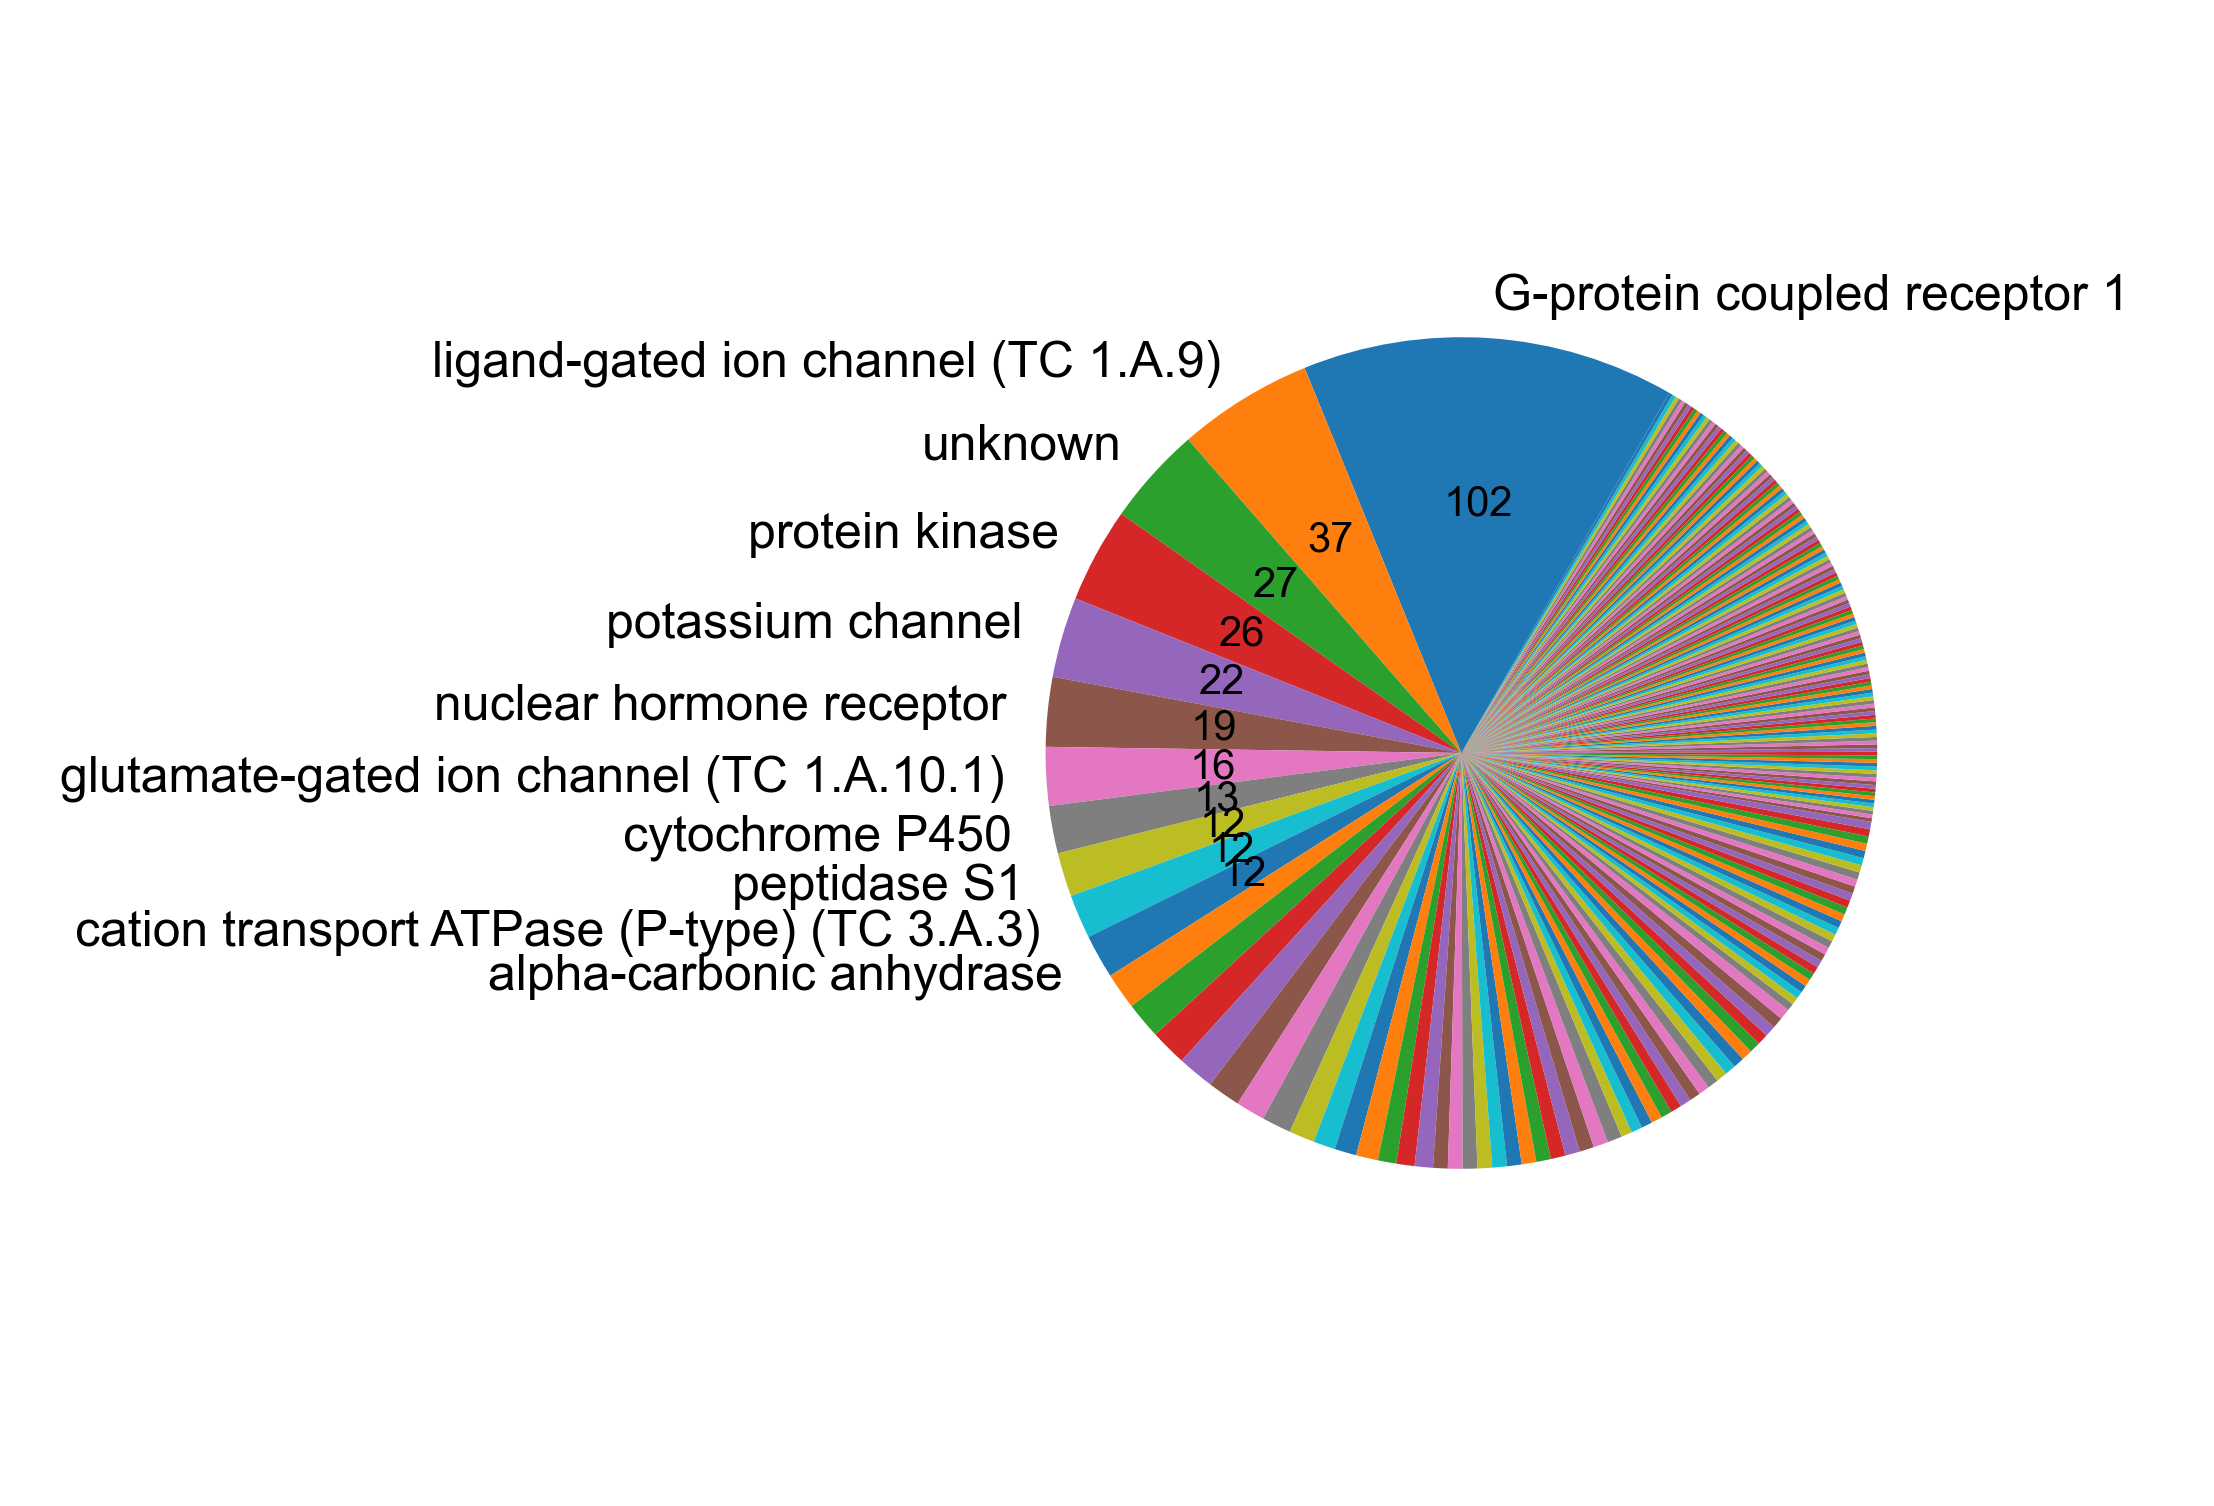

In [12]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        # 同时显示数值和占比的饼图
        # return '{p:.2f}% ({v:d})'.format(p=pct,v=val)
        if val > 10:
            return f'{val}'
        return ''
    return my_autopct

x = list(nps_new_family_counts_sort.values())
labels = [k if v > 10 else '' for k, v in nps_new_family_counts_sort.items()]
plt.figure(figsize=(3,3), dpi=600)
patches, l_text, p_text = plt.pie(
    x, labels=labels, autopct=make_autopct(x),radius=0.75, startangle=60)
for t in p_text:
    t.set_size(5)
for t in l_text:
    t.set_size(6)
# plt.title('Family/superfamily of nps targets', fontsize=7)
plt.savefig('./output/figures/approved_drug_nps_targets_family.png', dpi=600, bbox_inches='tight')
plt.show()

In [10]:
# with open('./data/Binding_data/TTD_DrugBank_target_family_mol_maps.pkl', 'wb') as file:
#     pkl.dump((ps_new_family_map_uniprots_sort, ps_new_family_mol_maps, nps_new_family_map_uniprots_sort, nps_new_family_mol_maps), file=file)

### Similarity comparison & remove redundance
+ More similar in the same protein family
+ remove redundance: cut-off, tanimotor similarity=0.8

In [14]:
with open('./data/Binding_data/TTD_DrugBank_ps_target_smiles_top5.txt', 'r') as file:
    ps_target_mols = file.read().strip().split('\n')

with open('./data/Binding_data/TTD_DrugBank_nps_target_smiles_top5.txt', 'r') as file:
    nps_target_mols = file.read().strip().split('\n')

ps_target_mol_morgan_fps, nps_target_mol_morgan_fps = [], []

for smi in ps_target_mols:
    mol = get_mol(smi)
    fp = [x for x in AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048)]
    ps_target_mol_morgan_fps.append(fp)

for smi in nps_target_mols:
    mol = get_mol(smi)
    fp = [x for x in AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048)]
    nps_target_mol_morgan_fps.append(fp)

ps_target_mol_morgan_fps = np.array(ps_target_mol_morgan_fps, dtype=np.int64)
nps_target_mol_morgan_fps = np.array(nps_target_mol_morgan_fps, dtype=np.int64)

In [15]:
from utils import tanimoto_similarity_smiles, tanimoto_similarity_fp

ps_target_mol_sim_mat = np.zeros(shape=(len(ps_target_mols), len(ps_target_mols)), dtype=np.float32)
for i in tqdm(range(len(ps_target_mols))):
    for j in range(len(ps_target_mols)):
        fp1 = ps_target_mol_morgan_fps[i]
        fp2 = ps_target_mol_morgan_fps[j]
        ps_target_mol_sim_mat[i, j] = tanimoto_similarity_fp(fp1, fp2)

nps_target_mol_sim_mat = np.zeros(shape=(len(nps_target_mols), len(nps_target_mols)), dtype=np.float32)
for i in tqdm(range(len(nps_target_mols))):
    for j in range(len(nps_target_mols)):
        fp1 = nps_target_mol_morgan_fps[i]
        fp2 = nps_target_mol_morgan_fps[j]
        nps_target_mol_sim_mat[i, j] = tanimoto_similarity_fp(fp1, fp2)

100%|██████████| 1784/1784 [01:58<00:00, 15.09it/s]


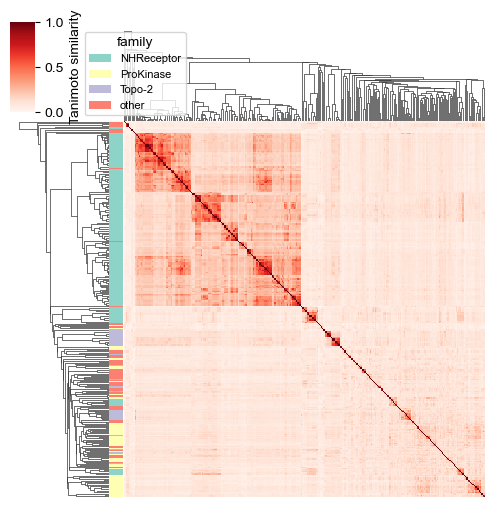

In [16]:
map_families = []
for smi in ps_target_mols:
    if smi in ps_new_family_mol_maps['nuclear hormone receptor']:
        map_families.append('NHReceptor')
    elif smi in ps_new_family_mol_maps['protein kinase']:
        map_families.append('ProKinase')
    elif smi in ps_new_family_mol_maps['type II topoisomerase']:
        map_families.append('Topo-2')
    else:
        map_families.append('other')

from matplotlib.patches import Patch
handles = [Patch(facecolor=sns.color_palette('Set3', 4)[i]) for i in range(4)]
lut = {
    'NHReceptor': 0,
    'ProKinase': 1,
    'Topo-2':2,
    'other': 3
}
colors = [sns.color_palette('Set3', 4)[lut[f]] for f in map_families]
# plt.figure(dpi=300, figsize=(6,6))
sns.clustermap(ps_target_mol_sim_mat, cmap='Reds', xticklabels=False, yticklabels=False, 
               row_colors=colors, cbar_kws={'label': 'Tanimoto similarity'}, metric='cosine', figsize=(5,5),
               )

plt.legend(handles, lut, title='family', bbox_to_anchor=(5,0.95), loc='upper center', fontsize=8)
# plt.savefig('./output/figures/approved_drug_ps_target_mol_similarity.pdf', dpi=600, bbox_inches='tight')
plt.savefig('./output/figures/approved_drug_ps_target_mol_similarity.png', dpi=600, bbox_inches='tight')

plt.show()

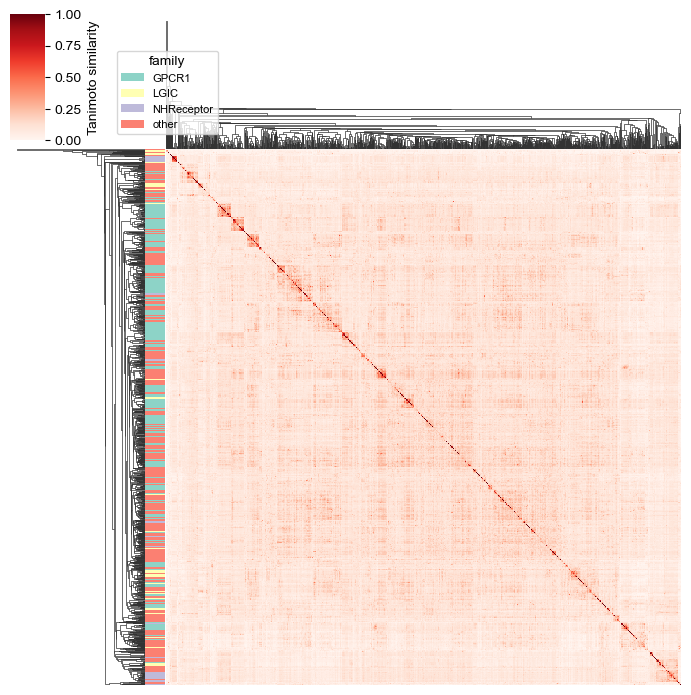

In [15]:
nps_map_families = []
for smi in nps_target_mols:
    if smi in nps_new_family_mol_maps['G-protein coupled receptor 1']:
        nps_map_families.append('GPCR1')
    elif smi in nps_new_family_mol_maps['ligand-gated ion channel (TC 1.A.9)']:
        nps_map_families.append('LGIC')
    elif smi in nps_new_family_mol_maps['nuclear hormone receptor']:
        nps_map_families.append('NHReceptor')
    else:
        nps_map_families.append('other')

handles = [Patch(facecolor=sns.color_palette('Set3', 4)[i]) for i in range(4)]
lut = {
    'GPCR1': 0,
    'LGIC': 1,
    'NHReceptor': 2,
    'other': 3
}
colors = [sns.color_palette('Set3', 4)[lut[f]] for f in nps_map_families]
sns.clustermap(nps_target_mol_sim_mat, cmap='Reds', xticklabels=False, yticklabels=False, 
               row_colors=colors, cbar_kws={'label': 'Tanimoto similarity'}, metric='cosine', figsize=(7,7))

plt.legend(handles, lut, title='family', bbox_to_anchor=(4.5,0.75), loc='upper center', fontsize=8)
# plt.savefig('./output/figures/approved_drug_nps_target_mol_similarity.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
from utils import remove_redundance

cutoff = 0.8 # 0.5 0.8
ps_target_non_redundant_dict = {key: remove_redundance(lst, cutoff=cutoff) for key, lst in ps_new_family_mol_maps.items()}
nps_target_non_redundant_dict = {key: remove_redundance(lst, cutoff=cutoff) for key, lst in nps_new_family_mol_maps.items()}

In [17]:
ps_target_non_redundant_smiles, nps_target_non_redundant_smiles = set(), set()
for _, lst in ps_target_non_redundant_dict.items():
    ps_target_non_redundant_smiles.update(lst)
for _, lst in nps_target_non_redundant_dict.items():
    nps_target_non_redundant_smiles.update(lst)

len(ps_target_non_redundant_smiles), len(nps_target_non_redundant_smiles)  # 272 1459, a little difference

(275, 1465)

In [19]:
len(ps_target_non_redundant_dict), len(nps_target_non_redundant_dict)

(30, 247)

In [21]:
# len(ps_new_family_map_uniprots_sort), len(nps_new_family_map_uniprots_sort)  # 26 221

(26, 221)

In [49]:
# save
# with open('./data/Binding_data/nonredundant/TTD_DrugBank_nonredundant0.8_drug_data.pkl', 'wb') as file:
#     pkl.dump((ps_target_non_redundant_dict, nps_target_non_redundant_dict), file=file)

# with open('./data/Binding_data/nonredundant/TTD_DrugBank_nonredundant0.8_ps_target_smiles.txt', 'w') as file:
#     for smi in ps_target_non_redundant_smiles:
#         file.write(smi + '\n')

# with open('./data/Binding_data/nonredundant/TTD_DrugBank_nonredundant0.8_nps_target_smiles.txt', 'w') as file:
#     for smi in nps_target_non_redundant_smiles:
#         file.write(smi + '\n')

### PS-drugs vs NPS-drugs

In [13]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, rdFreeSASA
from rdkit.Chem import MolSurf
from scipy.stats import mannwhitneyu, ttest_rel
from rdkit.Chem import Descriptors
from rdkit.Chem import MACCSkeys
lg = rdkit.RDLogger.logger() 
lg.setLevel(rdkit.RDLogger.CRITICAL)

In [14]:
# load
with open('./data/Binding_data/nonredundant/TTD_DrugBank_nonredundant0.8_ps_target_smiles.txt', 'r') as file:
    ps_target_mols = file.read().strip().split('\n')
with open('./data/Binding_data/nonredundant/TTD_DrugBank_nonredundant0.8_nps_target_smiles.txt', 'r') as file:
    nps_target_mols = file.read().strip().split('\n')

# # ADMETlab2.0 results
# ps_drugs_df = pd.read_csv('./output/ADMETlab2.0/TTD_DrugBank_nonredundant0.8_ps_drugs_properties.csv')
# nps_drugs_df = pd.read_csv('./output/ADMETlab2.0/TTD_DrugBank_nonredundant0.8_nps_drugs_properties.csv')
# using ADMETlab3.0 results
ps_drugs_df = pd.read_csv('./output/ADMETlab3.0/TTD_DrugBank_nonredundant0.8_ps_drugs_properties.csv')
nps_drugs_df = pd.DataFrame()
for i in range(3):
    tmp = pd.read_csv(f'D:/study_data/ADMETlab2.0/ADMETlab3.0/NPS_drugs_p{i+1}.csv')
    nps_drugs_df = pd.concat([nps_drugs_df, tmp], axis=0)
print(len(ps_target_mols), len(nps_target_mols), ps_drugs_df.shape, nps_drugs_df.shape)
nps_drugs_df.to_csv('./output/ADMETlab3.0/TTD_DrugBank_nonredundant0.8_nps_drugs_properties.csv', index=False)

272 1459 (272, 122) (1459, 122)


In [16]:
# Method 1: by Rdkit
ps_logps = [Descriptors.MolLogP(get_mol(smi)) for smi in ps_target_mols]
nps_logps = [Descriptors.MolLogP(get_mol(smi)) for smi in nps_target_mols]
print(mannwhitneyu(ps_logps, nps_logps, alternative='greater'))

# Method 2: by ADMETlab2.0
# logP
admet_ps_logps = ps_drugs_df.logP.tolist()
admet_nps_logps = nps_drugs_df.logP.tolist()
print(mannwhitneyu(admet_ps_logps, admet_nps_logps, alternative='greater'))

# logD7.4
admet_ps_logDs = ps_drugs_df.logD.tolist()
admet_nps_logDs = nps_drugs_df.logD.tolist()
print(mannwhitneyu(admet_ps_logDs, admet_nps_logDs, alternative='greater'))

# logS
admet_ps_logSs = ps_drugs_df.logS.tolist()
admet_nps_logSs = nps_drugs_df.logS.tolist()
print(mannwhitneyu(admet_ps_logSs, admet_nps_logSs, alternative='less'))

MannwhitneyuResult(statistic=256126.0, pvalue=1.2281921329707254e-14)
MannwhitneyuResult(statistic=240565.5, pvalue=1.2874327612657832e-08)
MannwhitneyuResult(statistic=257259.0, pvalue=3.8065255516379434e-15)
MannwhitneyuResult(statistic=113197.0, pvalue=1.0214415914095379e-29)


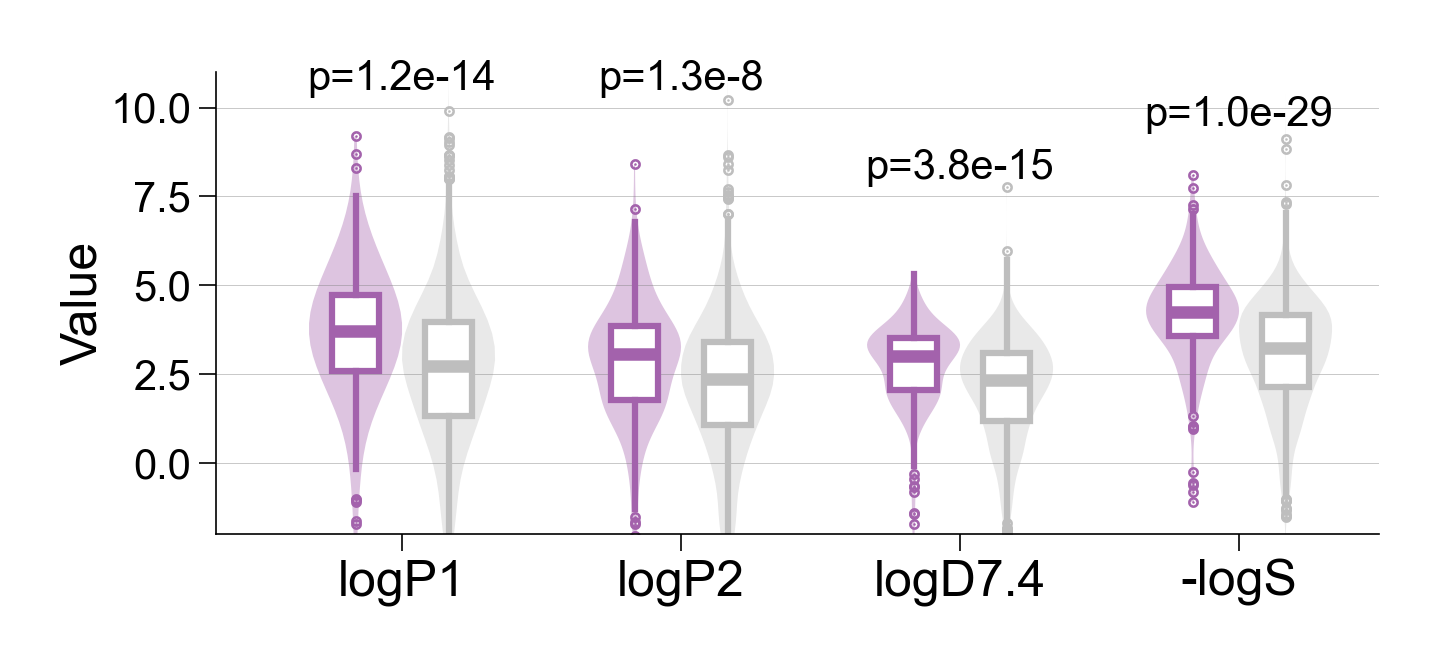

In [19]:
# violin plot + boxplot
fig, ax = plt.subplots(1, 1, figsize=(2.5,1), dpi=600)
# add horizontal lines
for h in [0,2.5, 5, 7.5, 10]:
    ax.axhline(h, color="#7F7F7F", alpha=0.5, linewidth=0.1, linestyle='-')

# Add violins ----------------------------------------------------
# bw_method="silverman" means the bandwidth of the kernel density
# estimator is computed via Silverman's rule of thumb. 
y_data = [ps_logps, nps_logps, admet_ps_logps, admet_nps_logps, 
          admet_ps_logDs, admet_nps_logDs, [-i for i in admet_ps_logSs], [-i for i in admet_nps_logSs]]
positions = [-0.5, 0.5, 2.5, 3.5, 5.5, 6.5, 8.5, 9.5]
positions = [i+2 for i in positions]
violins = ax.violinplot(dataset=y_data, positions=positions,
                        widths=1, bw_method='silverman', showmeans=False,
                        showmedians=False, showextrema=False)
# Customize violins (remove fill, customize line, etc.)
for i, pc in enumerate(violins["bodies"]):
    if i % 2 == 0:
        pc.set_facecolor('#DDC4E0')  # '#DDC4E0', '#E9E9E9'
    else:
        pc.set_facecolor('#E9E9E9')
    pc.set_edgecolor(None)
    pc.set_linewidth(0.1)
    pc.set_alpha(1)

medianprops = dict(
    linewidth=1.5, 
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=0.75, 
    # edgecolor='#DDA2E0', # #DDA2E0
    facecolor='white',
)
whiskerprops = dict(
    linewidth=0.75, 
    # color='#DDA2E0', # #DDA2E0
)

boxes = ax.boxplot(
    y_data,
    positions=positions, 
    showfliers = True, # Do not show the outliers beyond the caps.
    showcaps = False,   # Do not show the caps
    patch_artist=True,
    medianprops = medianprops,
    whiskerprops = whiskerprops,
    boxprops = boxprops, 
    flierprops={'markersize': 0.3, 'marker': 'o'}
)
# for box in boxes['boxes']:
#     box.set_edgecolor('#A362AC')
#     box.set_alpha(0.45)
for i, box in enumerate(boxes['boxes']):
    if i % 2 == 0:
        box.set_edgecolor('#A362AC')
    else:
        box.set_edgecolor('#BEBEBE')

for i, whisker in enumerate(boxes['whiskers']):
    if i % 4 == 0 or i % 4 == 1:
        whisker.set_color('#A362AC')
    else:
        whisker.set_color('#BEBEBE')

for i, median in enumerate(boxes['medians']):
    if i % 2 == 0:
        median.set_color('#A362AC')
    else:
        median.set_color('#BEBEBE')

for i, flier in enumerate(boxes['fliers']):
    if i % 2 == 0:
        flier.set_markeredgecolor('#A362AC')
        flier.set_markerfacecolor('#A362AC')
    else:
        flier.set_markeredgecolor('#BEBEBE')
        flier.set_markerfacecolor('#BEBEBE')

ax.set_ylim(-2, 11)
ax.set_xlim(0, 12.5)
ax.set_yticks([0, 2.5, 5, 7.5, 10])
ax.set_ylabel('Value', fontsize=6, labelpad=0.5)
ax.spines['left'].set_linewidth(0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_linewidth(0.2)
ax.tick_params(labelsize=5, width=0.2, length=2, pad=1)
ax.set_xticks([2, 5, 8, 11], ['logP1', 'logP2', 'logD7.4', '-logS'], fontsize=6)

ax.text(2, 10.5, 'p=1.2e-14', horizontalalignment='center', fontsize=5)
ax.text(5, 10.5, 'p=1.3e-8', horizontalalignment='center', fontsize=5)
ax.text(8, 8., 'p=3.8e-15', horizontalalignment='center', fontsize=5)
ax.text(11, 9.5, 'p=1.0e-29', horizontalalignment='center', fontsize=5)
plt.savefig('./output/figures/approved_drug_logp_ps_vs_nps.pdf', dpi=600, bbox_inches='tight')
plt.savefig('./output/figures/approved_drug_logp_ps_vs_nps.png', dpi=600, bbox_inches='tight')

plt.show()